In [5]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [6]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

In [7]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [8]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0
        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS_CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
        
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용
            # np.save(train_acc_file_name, train_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [9]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "4,5",
                my_seed = 42,
                TIME = 8, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 28, # dvscifar 48 # MNIST 28 # CIFAR10 32

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'MNIST',# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0, # nda 0.5  # ottt 1.0
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # 10000 이상은 separable, 20000이상은 depthwise
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                cfg = [64,20064], # vanilla conv, depthwise, separable
                
                net_print = False, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐
                validation_interval = 50, #숫자 크게 하면 꺼짐
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


My Num of PARAMS: 503,050, system's param_num : 503,306
Memory: 1.92MiB at 32-bit
EPOCH 0


train: 0-468/469 tr_acc: 91.67%, lr=['0.001'], tr_loss: 0.2633202075958252, val_acc: 93.91%: 100%|██████████| 469/469 [01:04<00:00,  7.33it/s] 

epoch_time: 64.1655626296997 seconds


EPOCH 1



train: 1-468/469 tr_acc: 96.88%, lr=['0.0009990133642141358'], tr_loss: 0.12285766005516052, val_acc: 95.20%: 100%|██████████| 469/469 [01:00<00:00,  7.74it/s]

epoch_time: 60.81136727333069 seconds


EPOCH 2



train: 2-468/469 tr_acc: 95.83%, lr=['0.000996057350657239'], tr_loss: 0.1835690140724182, val_acc: 95.93%: 100%|██████████| 469/469 [00:59<00:00,  7.82it/s]  

epoch_time: 60.14681696891785 seconds


EPOCH 3



train: 3-468/469 tr_acc: 93.75%, lr=['0.0009911436253643444'], tr_loss: 0.20475703477859497, val_acc: 95.46%: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s] 

epoch_time: 59.758288860321045 seconds


EPOCH 4



train: 4-468/469 tr_acc: 97.92%, lr=['0.0009842915805643156'], tr_loss: 0.13730022311210632, val_acc: 93.76%: 100%|██████████| 469/469 [01:00<00:00,  7.76it/s]  

epoch_time: 60.621835231781006 seconds


EPOCH 5



train: 5-468/469 tr_acc: 97.92%, lr=['0.0009755282581475769'], tr_loss: 0.12377145886421204, val_acc: 95.20%: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s] 

epoch_time: 61.03708004951477 seconds


EPOCH 6



train: 6-468/469 tr_acc: 97.92%, lr=['0.0009648882429441258'], tr_loss: 0.09127461165189743, val_acc: 93.81%: 100%|██████████| 469/469 [01:01<00:00,  7.61it/s]  

epoch_time: 61.75670266151428 seconds


EPOCH 7



train: 7-468/469 tr_acc: 91.67%, lr=['0.0009524135262330099'], tr_loss: 0.3382703363895416, val_acc: 95.04%: 100%|██████████| 469/469 [01:01<00:00,  7.67it/s]  

epoch_time: 61.281415939331055 seconds


EPOCH 8



train: 8-468/469 tr_acc: 96.88%, lr=['0.0009381533400219318'], tr_loss: 0.12500222027301788, val_acc: 95.43%: 100%|██████████| 469/469 [01:00<00:00,  7.74it/s]  

epoch_time: 60.76789140701294 seconds


EPOCH 9



train: 9-468/469 tr_acc: 95.83%, lr=['0.0009221639627510075'], tr_loss: 0.18639932572841644, val_acc: 96.08%: 100%|██████████| 469/469 [00:59<00:00,  7.88it/s]  

epoch_time: 59.68633317947388 seconds


EPOCH 10



train: 10-468/469 tr_acc: 97.92%, lr=['0.0009045084971874736'], tr_loss: 0.0980934426188469, val_acc: 96.11%: 100%|██████████| 469/469 [01:04<00:00,  7.28it/s]   

epoch_time: 64.57813835144043 seconds


EPOCH 11



train: 11-468/469 tr_acc: 97.92%, lr=['0.0008852566213878945'], tr_loss: 0.08725747466087341, val_acc: 96.56%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s]  

epoch_time: 65.6761884689331 seconds


EPOCH 12



train: 12-468/469 tr_acc: 97.92%, lr=['0.0008644843137107056'], tr_loss: 0.07666719704866409, val_acc: 96.81%: 100%|██████████| 469/469 [00:59<00:00,  7.82it/s]  

epoch_time: 60.10395526885986 seconds


EPOCH 13



train: 13-468/469 tr_acc: 92.71%, lr=['0.0008422735529643443'], tr_loss: 0.17945431172847748, val_acc: 96.98%: 100%|██████████| 469/469 [00:59<00:00,  7.83it/s]  

epoch_time: 60.062846422195435 seconds


EPOCH 14



train: 14-468/469 tr_acc: 100.00%, lr=['0.0008187119948743448'], tr_loss: 0.037002187222242355, val_acc: 97.10%: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]

epoch_time: 60.887085914611816 seconds


EPOCH 15



train: 15-468/469 tr_acc: 96.88%, lr=['0.0007938926261462366'], tr_loss: 0.06958571821451187, val_acc: 97.22%: 100%|██████████| 469/469 [00:59<00:00,  7.88it/s]  

epoch_time: 59.684606313705444 seconds


EPOCH 16



train: 16-468/469 tr_acc: 97.92%, lr=['0.0007679133974894982'], tr_loss: 0.07242359966039658, val_acc: 95.46%: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s]  

epoch_time: 59.811582803726196 seconds


EPOCH 17



train: 17-468/469 tr_acc: 100.00%, lr=['0.0007408768370508576'], tr_loss: 0.040987614542245865, val_acc: 94.83%: 100%|██████████| 469/469 [00:59<00:00,  7.84it/s]

epoch_time: 60.015235900878906 seconds


EPOCH 18



train: 18-468/469 tr_acc: 100.00%, lr=['0.0007128896457825362'], tr_loss: 0.038235895335674286, val_acc: 95.81%: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s]

epoch_time: 61.051416873931885 seconds


EPOCH 19



train: 19-468/469 tr_acc: 96.88%, lr=['0.0006840622763423389'], tr_loss: 0.10970976203680038, val_acc: 95.96%: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]  

epoch_time: 60.82581853866577 seconds


EPOCH 20



train: 20-468/469 tr_acc: 97.92%, lr=['0.0006545084971874735'], tr_loss: 0.054423049092292786, val_acc: 95.29%: 100%|██████████| 469/469 [00:59<00:00,  7.85it/s] 

epoch_time: 59.992597579956055 seconds


EPOCH 21



train: 21-468/469 tr_acc: 98.96%, lr=['0.0006243449435824271'], tr_loss: 0.06375615298748016, val_acc: 96.10%: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]  

epoch_time: 60.24018335342407 seconds


EPOCH 22



train: 22-468/469 tr_acc: 96.88%, lr=['0.0005936906572928622'], tr_loss: 0.06763025373220444, val_acc: 96.55%: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]  

epoch_time: 60.369816303253174 seconds


EPOCH 23



train: 23-468/469 tr_acc: 98.96%, lr=['0.000562666616782152'], tr_loss: 0.04703030362725258, val_acc: 96.58%: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s]  

epoch_time: 60.89890480041504 seconds


EPOCH 24



train: 24-468/469 tr_acc: 96.88%, lr=['0.0005313952597646566'], tr_loss: 0.09381083399057388, val_acc: 93.32%: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s]  

epoch_time: 59.80356478691101 seconds


EPOCH 25



train: 25-468/469 tr_acc: 97.92%, lr=['0.0004999999999999998'], tr_loss: 0.07518444955348969, val_acc: 93.27%: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]  

epoch_time: 60.32577109336853 seconds


EPOCH 26



train: 26-468/469 tr_acc: 96.88%, lr=['0.00046860474023534314'], tr_loss: 0.10144689679145813, val_acc: 95.38%: 100%|██████████| 469/469 [00:59<00:00,  7.82it/s]  

epoch_time: 60.21942639350891 seconds


EPOCH 27



train: 27-468/469 tr_acc: 97.92%, lr=['0.00043733338321784774'], tr_loss: 0.0751287117600441, val_acc: 96.77%: 100%|██████████| 469/469 [01:01<00:00,  7.66it/s]   

epoch_time: 61.44993209838867 seconds


EPOCH 28



train: 28-468/469 tr_acc: 98.96%, lr=['0.00040630934270713756'], tr_loss: 0.04733700677752495, val_acc: 96.54%: 100%|██████████| 469/469 [00:59<00:00,  7.83it/s]  

epoch_time: 60.086639165878296 seconds


EPOCH 29



train: 29-468/469 tr_acc: 96.88%, lr=['0.00037565505641757246'], tr_loss: 0.07657121866941452, val_acc: 93.84%: 100%|██████████| 469/469 [00:59<00:00,  7.83it/s]  

epoch_time: 60.066821575164795 seconds


EPOCH 30



train: 30-468/469 tr_acc: 97.92%, lr=['0.00034549150281252633'], tr_loss: 0.041242342442274094, val_acc: 96.72%: 100%|██████████| 469/469 [01:01<00:00,  7.58it/s] 

epoch_time: 62.0661997795105 seconds


EPOCH 31



train: 31-468/469 tr_acc: 100.00%, lr=['0.00031593772365766105'], tr_loss: 0.0388612374663353, val_acc: 97.72%: 100%|██████████| 469/469 [01:01<00:00,  7.65it/s]  

epoch_time: 61.5770788192749 seconds


EPOCH 32



train: 32-468/469 tr_acc: 97.92%, lr=['0.00028711035421746355'], tr_loss: 0.08326911926269531, val_acc: 96.00%: 100%|██████████| 469/469 [01:01<00:00,  7.64it/s]  

epoch_time: 61.58501434326172 seconds


EPOCH 33



train: 33-468/469 tr_acc: 98.96%, lr=['0.0002591231629491422'], tr_loss: 0.050081443041563034, val_acc: 95.10%: 100%|██████████| 469/469 [01:01<00:00,  7.63it/s] 

epoch_time: 61.651108503341675 seconds


EPOCH 34



train: 34-468/469 tr_acc: 98.96%, lr=['0.00023208660251050145'], tr_loss: 0.05139530077576637, val_acc: 94.50%: 100%|██████████| 469/469 [01:02<00:00,  7.48it/s]  

epoch_time: 62.8630096912384 seconds


EPOCH 35



train: 35-468/469 tr_acc: 98.96%, lr=['0.00020610737385376337'], tr_loss: 0.04572005942463875, val_acc: 97.07%: 100%|██████████| 469/469 [01:02<00:00,  7.50it/s]  

epoch_time: 62.74306583404541 seconds


EPOCH 36



train: 36-468/469 tr_acc: 96.88%, lr=['0.00018128800512565502'], tr_loss: 0.07219681888818741, val_acc: 97.01%: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]  

epoch_time: 62.43421816825867 seconds


EPOCH 37



train: 37-468/469 tr_acc: 98.96%, lr=['0.00015772644703565555'], tr_loss: 0.05208950117230415, val_acc: 95.24%: 100%|██████████| 469/469 [01:00<00:00,  7.75it/s]  

epoch_time: 60.7851984500885 seconds


EPOCH 38



train: 38-468/469 tr_acc: 98.96%, lr=['0.00013551568628929425'], tr_loss: 0.040777649730443954, val_acc: 96.37%: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s] 

epoch_time: 61.06735634803772 seconds


EPOCH 39



train: 39-468/469 tr_acc: 100.00%, lr=['0.00011474337861210535'], tr_loss: 0.03753354027867317, val_acc: 97.48%: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s] 

epoch_time: 61.08596968650818 seconds


EPOCH 40



train: 40-468/469 tr_acc: 98.96%, lr=['9.549150281252626e-05'], tr_loss: 0.0370321162045002, val_acc: 95.28%: 100%|██████████| 469/469 [01:01<00:00,  7.68it/s]   

epoch_time: 61.27373766899109 seconds


EPOCH 41



train: 41-468/469 tr_acc: 98.96%, lr=['7.783603724899252e-05'], tr_loss: 0.033572982996702194, val_acc: 96.96%: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s] 

epoch_time: 61.083985805511475 seconds


EPOCH 42



train: 42-468/469 tr_acc: 98.96%, lr=['6.184665997806817e-05'], tr_loss: 0.06488984823226929, val_acc: 97.23%: 100%|██████████| 469/469 [01:02<00:00,  7.46it/s]  

epoch_time: 63.07310199737549 seconds


EPOCH 43



train: 43-62/469 tr_acc: 98.44%, lr=['4.7586473766990294e-05'], tr_loss: 0.04131333529949188, val_acc: 97.00%:  13%|█▎        | 63/469 [00:07<00:51,  7.94it/s]  


KeyboardInterrupt: 

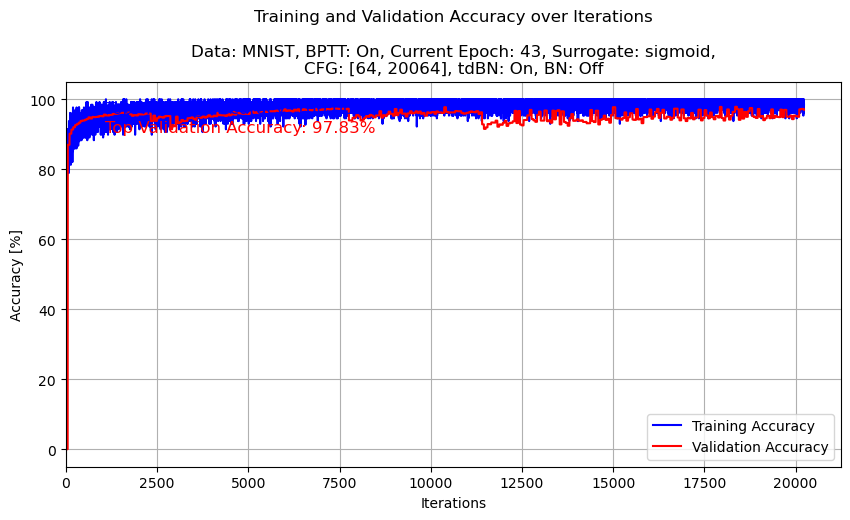

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# 텍스트 추가
plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()